In [1]:
!pip install transformers --quiet
!pip install wget --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [3]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 128
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            eps = 1e-8,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test,digits=4))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            
            plot_cm(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [5]:
import wget
import os
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [6]:
import pandas as pd
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.15, random_state=42)
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1764705882352941, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12250,)
(10088,)
(2162,)
(2162,)


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**********
Model: cointegrated/rubert-tiny
Epoch 1/7


100%|██████████| 5044/5044 [02:05<00:00, 40.05it/s]


Train loss 0.558978428835063 accuracy 0.8240483743061062
Valid:
Accuracy: 87.6 %
Recall: 80.73 %
precision: 0.8633500198756257, recall: 0.8594529743626366, f1score: 0.8613382191475288
Test:
Accuracy: 89.69 %
Recall: 83.5 %
precision: 0.8834011260394663, recall: 0.8808274924757014, f1score: 0.882092501893486
*********************
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1459
           1       0.85      0.83      0.84       703

    accuracy                           0.90      2162
   macro avg       0.88      0.88      0.88      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 89.69 %
Recall: 83.5 %
Precision: 84.58 %
F1-score: 84.04 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1352
False Positives:  107
False Negatives:  116
True Positives:  587
Epoch 2/7


100%|██████████| 5044/5044 [02:03<00:00, 40.84it/s]


Train loss 0.436016336114247 accuracy 0.897898493259318
Valid:
Accuracy: 88.16 %
Recall: 81.0 %
precision: 0.8703443976936263, recall: 0.8643185983955819, f1score: 0.8671869075900462
Test:
Accuracy: 90.19 %
Recall: 84.07 %
precision: 0.8895717592706459, recall: 0.8860713460475373, f1score: 0.8877823534308421
*********************
              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1459
           1       0.86      0.84      0.85       703

    accuracy                           0.90      2162
   macro avg       0.89      0.89      0.89      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 90.19 %
Recall: 84.07 %
Precision: 85.53 %
F1-score: 84.79 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1359
False Positives:  100
False Negatives:  112
True Positives:  591
Epoch 3/7


100%|██████████| 5044/5044 [02:02<00:00, 41.22it/s]


Train loss 0.3458333033226216 accuracy 0.9261498810467883
Valid:
Accuracy: 88.67 %
Recall: 82.23 %
precision: 0.8754103097549699, recall: 0.8711261872455902, f1score: 0.8731955399034621
Test:
Accuracy: 89.78 %
Recall: 83.78 %
precision: 0.8842508742218249, recall: 0.882249967582387, f1score: 0.8832372329441665
*********************
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1459
           1       0.85      0.84      0.84       703

    accuracy                           0.90      2162
   macro avg       0.88      0.88      0.88      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 89.78 %
Recall: 83.78 %
Precision: 84.63 %
F1-score: 84.2 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1352
False Positives:  107
False Negatives:  114
True Positives:  589
Epoch 4/7


100%|██████████| 5044/5044 [02:03<00:00, 40.99it/s]


Train loss 0.27453002020399825 accuracy 0.9421094369547978
Valid:
Accuracy: 89.5 %
Recall: 84.67 %
precision: 0.8830872613501416, recall: 0.8833378561736771, f1score: 0.8832123076190873
Test:
Accuracy: 90.43 %
Recall: 85.49 %
precision: 0.8906099212402329, recall: 0.8914702191820622, f1score: 0.8910376445467572
*********************
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1459
           1       0.85      0.85      0.85       703

    accuracy                           0.90      2162
   macro avg       0.89      0.89      0.89      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 90.43 %
Recall: 85.49 %
Precision: 85.13 %
F1-score: 85.31 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1354
False Positives:  105
False Negatives:  102
True Positives:  601
Epoch 5/7


100%|██████████| 5044/5044 [02:02<00:00, 41.01it/s]


Train loss 0.22497262485468444 accuracy 0.9555908009516257
Valid:
Accuracy: 88.95 %
Recall: 87.92 %
precision: 0.8733904041628999, recall: 0.8869885024637578, f1score: 0.8793029386036114
Test:
Accuracy: 90.01 %
Recall: 88.62 %
precision: 0.8818980971511263, recall: 0.8964937304824033, f1score: 0.8883927419146684
*********************
              precision    recall  f1-score   support

           0       0.94      0.91      0.92      1459
           1       0.82      0.89      0.85       703

    accuracy                           0.90      2162
   macro avg       0.88      0.90      0.89      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 90.01 %
Recall: 88.62 %
Precision: 82.08 %
F1-score: 85.23 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1323
False Positives:  136
False Negatives:  80
True Positives:  623
Epoch 6/7


100%|██████████| 5044/5044 [02:02<00:00, 41.24it/s]


Train loss 0.18120305672902087 accuracy 0.9638183980967486
Valid:
Accuracy: 89.55 %
Recall: 84.94 %
precision: 0.8833451571330753, recall: 0.8843438310838154, f1score: 0.8838404826183414
Test:
Accuracy: 90.38 %
Recall: 85.63 %
precision: 0.8897859299906715, recall: 0.8914960557758437, f1score: 0.89063132335087
*********************
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1459
           1       0.85      0.86      0.85       703

    accuracy                           0.90      2162
   macro avg       0.89      0.89      0.89      2162
weighted avg       0.90      0.90      0.90      2162

Accuracy: 90.38 %
Recall: 85.63 %
Precision: 84.91 %
F1-score: 85.27 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1352
False Positives:  107
False Negatives:  101
True Positives:  602
Epoch 7/7


100%|██████████| 5044/5044 [02:02<00:00, 41.04it/s]


Train loss 0.1608332598752217 accuracy 0.9679817605075337
Valid:
Accuracy: 89.5 %
Recall: 86.7 %
precision: 0.8808649793758967, recall: 0.888251089052346, f1score: 0.8843222131737769
Test:
Accuracy: 90.52 %
Recall: 87.48 %
precision: 0.889312736443884, recall: 0.8973151391714935, f1score: 0.8930920239331455
*********************
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1459
           1       0.84      0.87      0.86       703

    accuracy                           0.91      2162
   macro avg       0.89      0.90      0.89      2162
weighted avg       0.91      0.91      0.91      2162

Accuracy: 90.52 %
Recall: 87.48 %
Precision: 84.02 %
F1-score: 85.71 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1342
False Positives:  117
False Negatives:  88
True Positives:  615
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

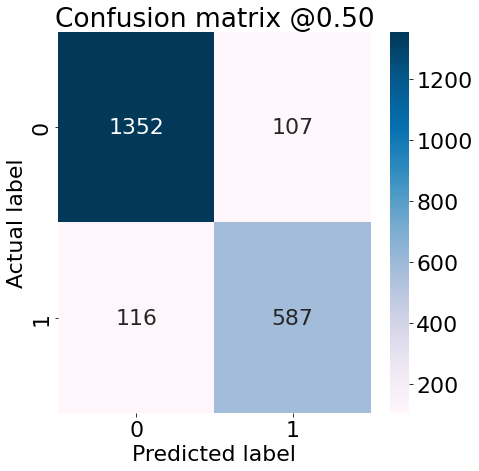

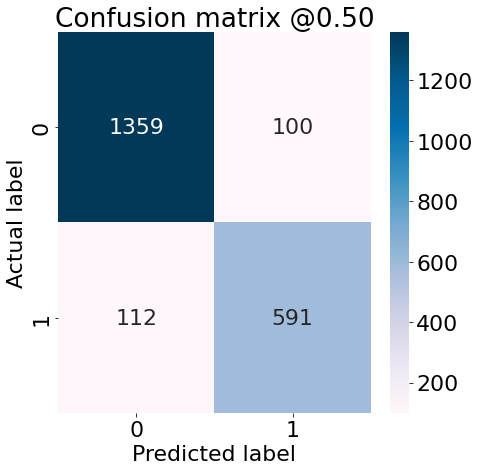

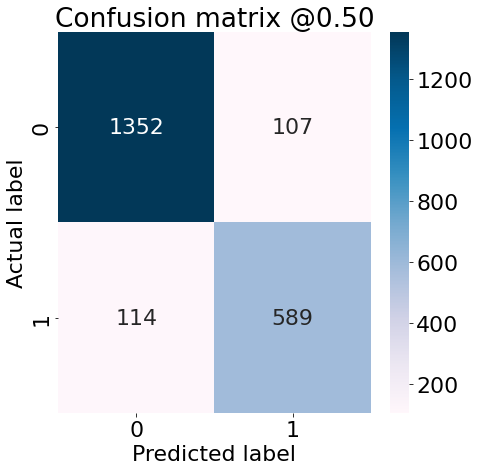

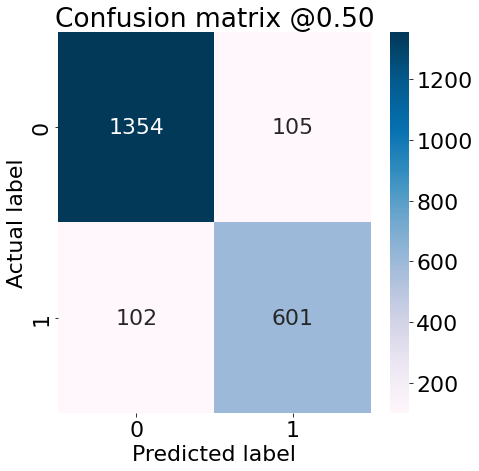

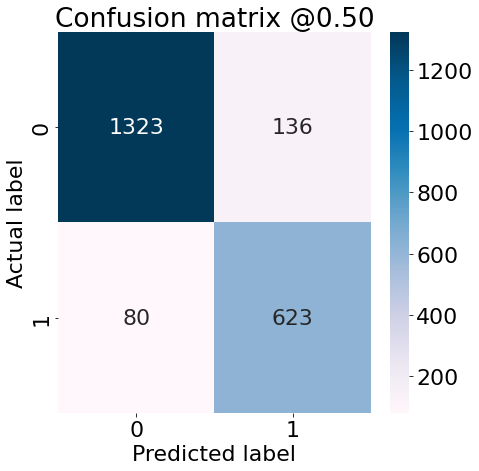

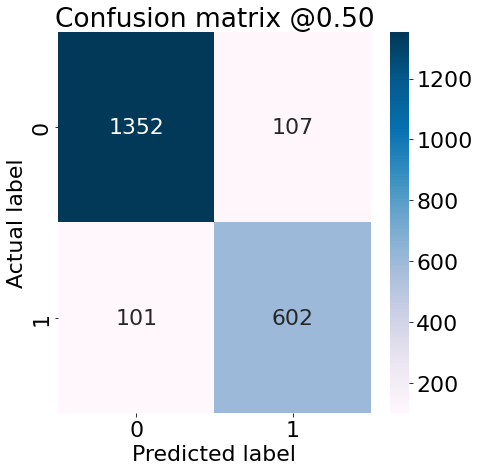

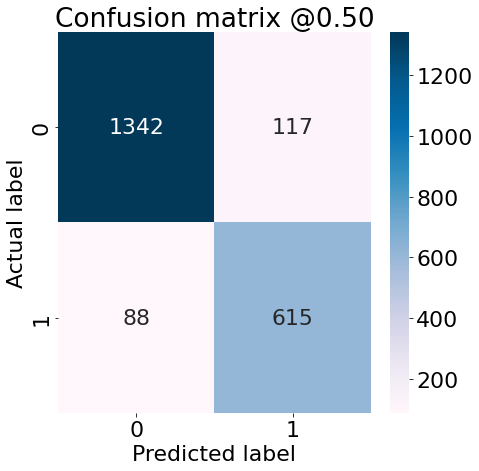

In [7]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny',
    n_classes=2
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_val,
        y_valid=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=7
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)